<center> 
    <h1>Bio-Informatics 4th Assignment</h1>
    <!-- <br> -->
    <h4></h4>
    <h3>Seyed Mohammad Hossein Hashemi</h3>
    <h5>Feb 2025</h5>
    <h1></h1>

</center>

### Importing the required packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import gc
import numpy as np
import seaborn as sns
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

from tqdm import tqdm
from IPython.display import Image, display 

### Read Me

The datasets I have used for this assignment are:
- AK2H_ECOLI (https://www.ncbi.nlm.nih.gov/protein/CAD09522.1?report=fasta)
- AK3_ECOLI (https://www.ncbi.nlm.nih.gov/protein/P08660.2?report=fasta)


# Data Preprocessing

In [2]:
def fasta_cleaner(path):
    """helper function, that cleans and extracts the ID and sequences from FASTA files"""
    raw_data = {}

    with open(path, "r") as file:
        lines = file.readlines()
        for i in range(len(lines)):
            lines[i] = lines[i].rstrip("\n")  

            # Header line ?
            if lines[i].startswith(">"):  
                # we will look for sequence on next lines ...
                raw_data[lines[i].lstrip(">")] = ""  
            else:  
                # Append sequence to the most recent header (Concatenate)
                last_key = list(raw_data.keys())[-1]  
                raw_data[last_key] += lines[i]  

    return raw_data


### Convert the FASTA file contents into a Pandas Data for better access

In [3]:
raw_data = fasta_cleaner("C:\\Users\\laste\\Desktop\\HW_lab\\df.fasta")

df = pd.DataFrame(data = raw_data.items(), columns = ['ID', 'Sequence'])
df.head()

,ID,Sequence
0,CAD09522.1 bifunctional aspartokinase II/homos...,MSVIAQAGAKGRQLHKFGGSSLADVKCYLRVAGIMAEYSQPDDMMV...
1,sp|P08660.2|AK3_ECOLI RecName: Full=Lysine-sen...,MSEIVVSKFGGTSVADFDAMNRSADIVLSDANVRLVVLSASAGITN...


### Data Extraction

In [4]:
df["ID"].unique()

array(['CAD09522.1 bifunctional aspartokinase II/homoserine dehydrogenase IIcan I write [Salmonella enterica subsp. enterica serovar Typhi str. CT18]',
       'sp|P08660.2|AK3_ECOLI RecName: Full=Lysine-sensitive aspartokinase 3; AltName: Full=Aspartate kinase III; Short=AKIII; AltName: Full=Lysine-sensitive aspartokinase III'],
      dtype=object)

In [5]:
# Encoding the values for better readability
df['Type'] = None

for row in range(0,len(df)):
    if "CAD09522.1 bifunctional" in df.loc[row].ID:
        df["Type"][row:row+1] = "AK2H_ECOLI"
    else:
        df["Type"][row:row+1] = "AK3_ECOLI"
        

In [6]:
df.drop(["ID"], axis =1, inplace = True)
df

,Sequence,Type
0,MSVIAQAGAKGRQLHKFGGSSLADVKCYLRVAGIMAEYSQPDDMMV...,AK2H_ECOLI
1,MSEIVVSKFGGTSVADFDAMNRSADIVLSDANVRLVVLSASAGITN...,AK3_ECOLI


In [7]:
seq_1_length = len(df[df["Type"] == "AK2H_ECOLI"]["Sequence"].values[0])
print(f"AK2H_ECOLI sequence length: {seq_1_length}")

seq_2_length = len(df[df["Type"] == "AK3_ECOLI"]["Sequence"].values[0])
print(f"AK3_ECOLI sequence length: {seq_2_length}")

AK2H_ECOLI sequence length: 810
AK3_ECOLI sequence length: 449


### Optional Investigation ...

In [8]:
def alignment_analsys(seq_1, seq_2):
    
    # Ensure both sequences are of the same length
    # temp_len = len(seq_1) if len(seq_1) <= len(seq_2) else len(seq_2) 
    # matrix = np.full((temp_len, temp_len), '', dtype='U1')

    """Instead of keeping the shorter sequence we decided to padd it to the same length as the larger one"""
    temp_len = max(len(seq_1), len(seq_2))
    seq_1 = seq_1.ljust(temp_len, '-')  # Padding with '-'
    seq_2 = seq_2.ljust(temp_len, '-')  # Padding with '-'
    matrix = np.full((temp_len, temp_len), '', dtype='U')

    
    # Compare each character of both sequences
    for i in range(temp_len):
        for j in range(temp_len):
            
            if seq_1[i] == seq_2[j]:
                # print(f"{seq_1[i]} = {seq_2[j]}\n")
                matrix[i][j] = '*'  # Match '*'
            else:
                matrix[i][j] = ' '  # Mismatch ' '
                # print(f"{seq_1[i]} != {seq_2[j]}\n")
    
    # print(f"Dot Matrix\n{matrix}")
    # print("Done!")
    return matrix


In [9]:
def viz_dot(M, name_1, name_2):
    """Simply visualizes the dot matrix"""
    plt.figure(figsize=(13, 13))
    plt.imshow(M == '*', cmap='Greys', interpolation='nearest') 
    plt.title(f"Dot Matrix for {name_1} & {name_2}", color = "Green", fontsize=16)
    plt.xlabel(f"{name_2}", color="red", fontsize=12)
    plt.ylabel(f"{name_1}", color="red", fontsize=12)
    plt.show()
    

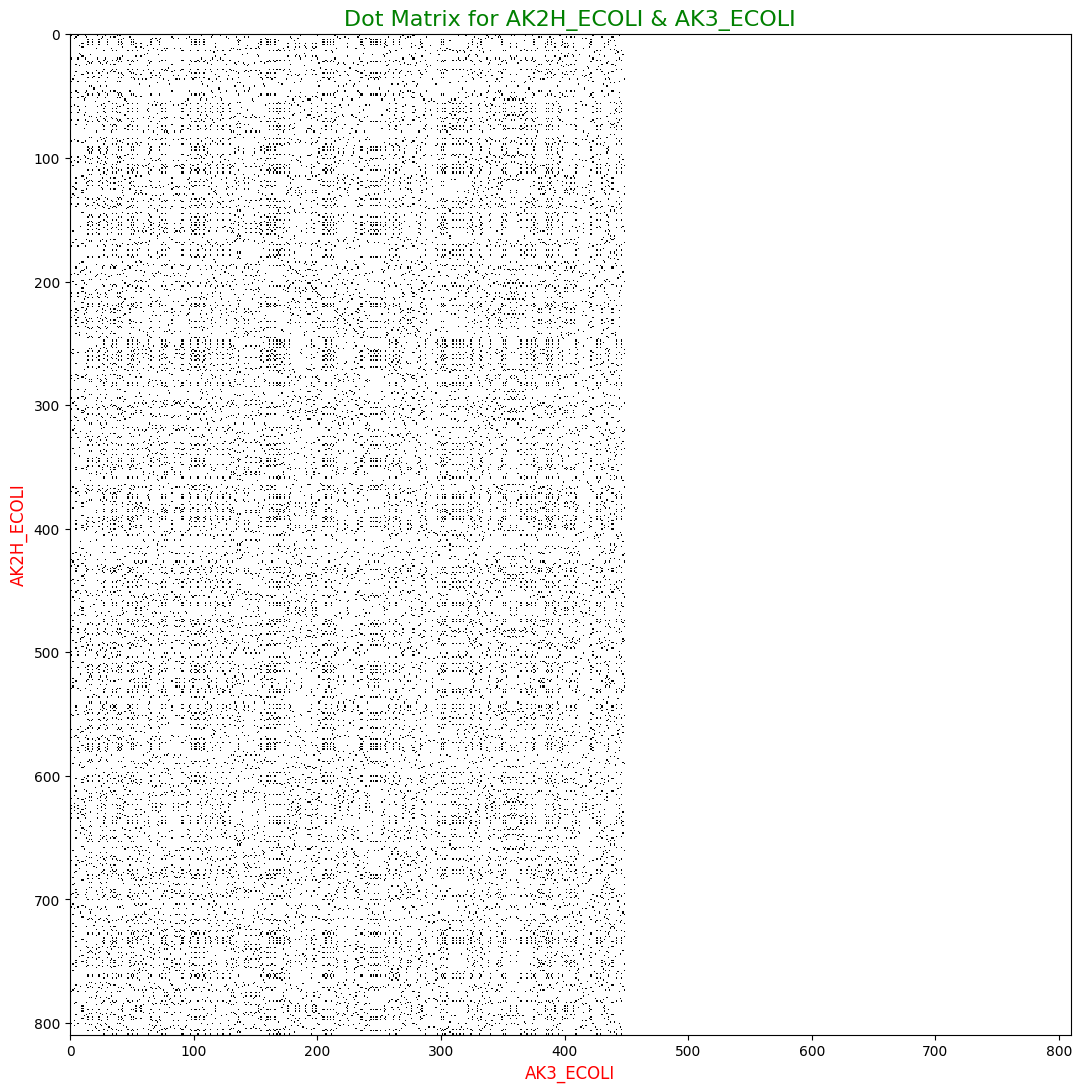

In [10]:
M = alignment_analsys(df["Sequence"][0], df["Sequence"][1])
viz_dot(M, "AK2H_ECOLI", "AK3_ECOLI")

# Global Alignment (Needleman-Wunsch Technique)

In [11]:
def Needleman_Wunch_galignment(seq_1, seq_2):
    """Calculates the NW global alignment between two sequences"""
    match_score = 2
    mismatch_penalty = -1
    gap_penalty = -2

    # Step 1: Initialization
    m = len(seq_1)  # rows
    n = len(seq_2)  # columns
    matrix = np.zeros((m + 1, n + 1)) 


    # Fill the first row and columns with penalty score multiplied with index
    for i in range(1, m + 1):
        matrix[i][0] = i * gap_penalty
    for j in range(1, n + 1):
        matrix[0][j] = j * gap_penalty

    # # Visualization Matrix
    # vis_matrix = np.copy(matrix)

    # Forward -----------------------------------------------------------------------------    
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            # loop over all the indices and Calculate the diagonal scores
            # They match?
            if seq_1[i - 1] == seq_2[j - 1]: 
                diagonal_score = matrix[i - 1][j - 1] + match_score
            # They dont match ...
            else:
                diagonal_score = matrix[i - 1][j - 1] + mismatch_penalty

            # Top and Left indices ...
            up_score = matrix[i - 1][j] + gap_penalty
            left_score = matrix[i][j - 1] + gap_penalty

            # Max [ (M_i-1,j-1 + S_i,j) , (M_i,j_1 + W) , (M_i-1,j + W) ]
            matrix[i][j] = max(diagonal_score, up_score, left_score)


    
    # Backward -----------------------------------------------------------------------------
    # Starting from top right bottom, iterate over neighbours (top/left)
    aligned_seq_1, aligned_seq_2 = "", "" 
    i, j = m, n  
    backward_path = []
    
    # Continue until both i and j reach 0
    while i > 0 or j > 0:
        if i > 0 and j > 0:  # This condition makes sure that the both sequences have something left to iterate over
            # calculating all the possible neighbour scores
            diagonal_score = matrix[i - 1][j - 1] + (match_score if seq_1[i - 1] == seq_2[j - 1] else mismatch_penalty)
            up_score = matrix[i - 1][j] + gap_penalty
            left_score = matrix[i][j - 1] + gap_penalty

            
            # if the current pointer value is equal to Diagonal neighbour it means that we took the diagonal move on forward 
            if matrix[i][j] == diagonal_score:
                aligned_seq_1 = seq_1[i - 1] + aligned_seq_1
                aligned_seq_2 = seq_2[j - 1] + aligned_seq_2
                backward_path.append([i-1,j-1]) # logging the path pt1
                i -= 1
                j -= 1

            # Same logic apllies to Left and Up neighbours
            elif matrix[i][j] == up_score:
                aligned_seq_1 = seq_1[i - 1] + aligned_seq_1
                aligned_seq_2 = "-" + aligned_seq_2
                backward_path.append([i-1,j]) # logging the path pt2
                i -= 1
            else:
                aligned_seq_1 = "-" + aligned_seq_1
                aligned_seq_2 = seq_2[j - 1] + aligned_seq_2
                backward_path.append([i,j-1]) # logging the path pt3
                j -= 1

                
        # Exception case: When one sequence is longer than the other
        elif i > 0: 
            aligned_seq_1 = seq_1[i - 1] + aligned_seq_1
            aligned_seq_2 = "-" + aligned_seq_2
            backward_path.append([i-1,j]) # logging the path pt4
            i -= 1
        else:  # Only seq_2 has characters left
            aligned_seq_1 = "-" + aligned_seq_1
            aligned_seq_2 = seq_2[j - 1] + aligned_seq_2
            backward_path.append([i,j-1]) # logging the path pt5
            j -= 1


    
    return aligned_seq_1, aligned_seq_2, matrix[m][n], matrix, backward_path[::-1]

# Test and Visualize the results

In [12]:
# changed the order of feeding for better visualization
aseq_1, aseq_2, score, viz_matrix, backward_path = Needleman_Wunch_galignment(df["Sequence"][1], df["Sequence"][0]) 

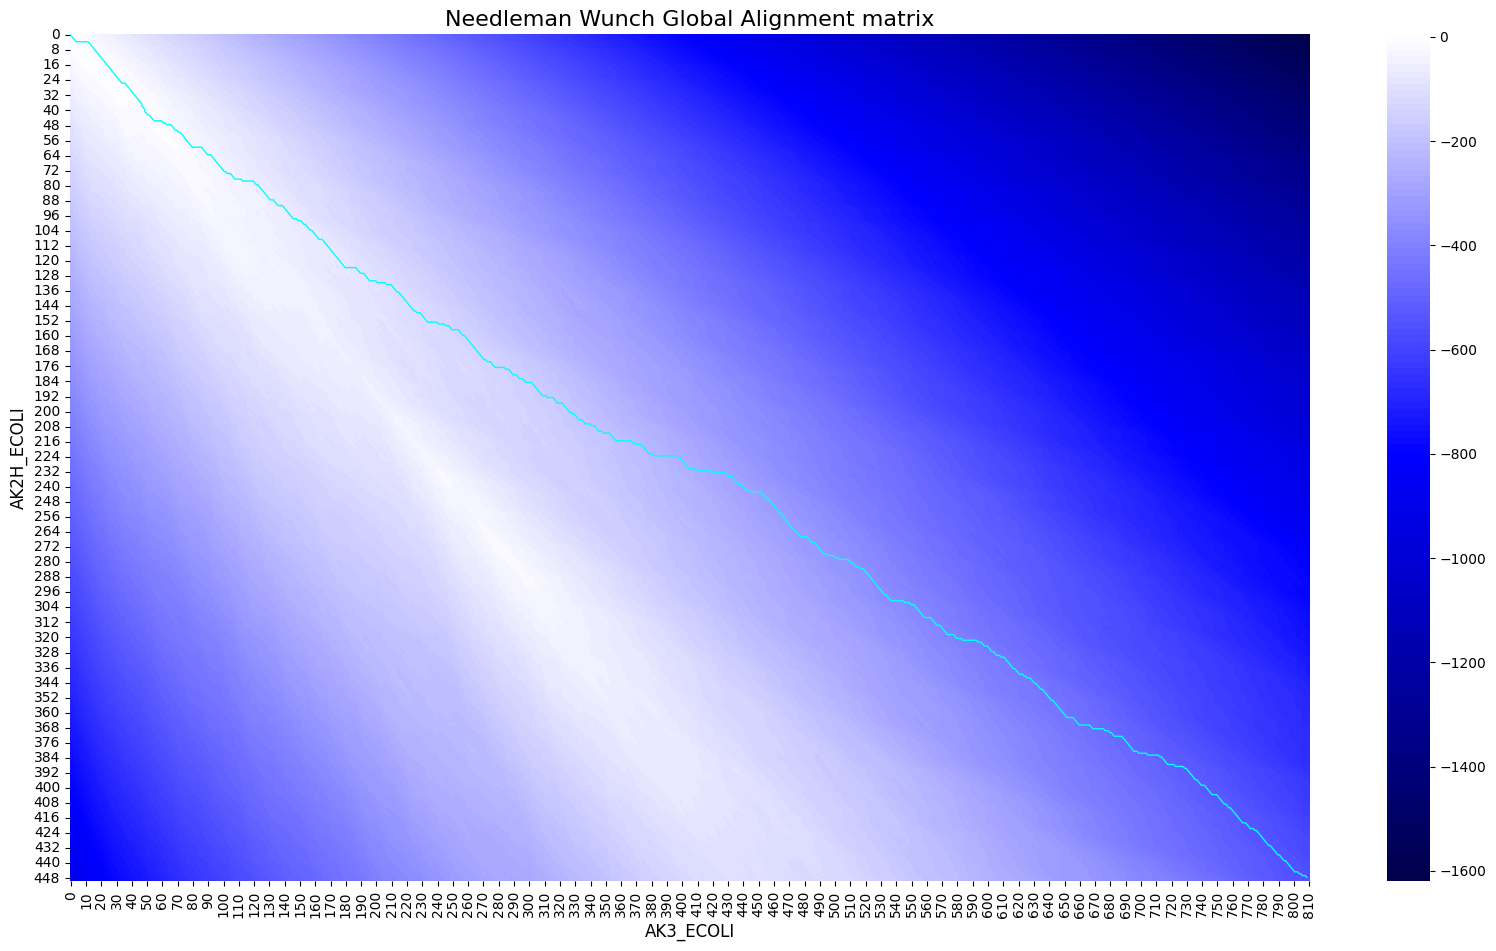

In [13]:
plt.figure(figsize=(int(len(df["Sequence"][0])/40), int(len(df["Sequence"][1])/40)) )
sns.heatmap(viz_matrix, cmap="seismic", center=0) # plotting the Alignmnet matrix (seismic for better distiction)

path_x = [x for x, y in backward_path]
path_y = [y for x, y in backward_path]
plt.plot(path_y, path_x, color='cyan', linewidth=1) # Optimal Path line

plt.title('Needleman Wunch Global Alignment matrix', fontsize=16)
plt.xlabel('AK3_ECOLI', fontsize=12)
plt.ylabel('AK2H_ECOLI', fontsize=12)
plt.show()

In [14]:
seq_1_length = len(aseq_1)
print(f"AK2H_ECOLI sequence length: {seq_1_length}")

seq_2_length = len(aseq_2)
print(f"AK3_ECOLI sequence length: {seq_2_length}")

AK2H_ECOLI sequence length: 812
AK3_ECOLI sequence length: 812


In [15]:
def seq_similarity_identity(seq_1, seq_2):
    """Calculates Similarity and Identity scores for a pair of sequences"""

    aa = ["A", "V", "I", "L", "M", "F", "Y", "W", "R", "H", "K", "D", "E", "S", "T", "N", "Q", "C", "U", "G", "P"]
    groups = ["HP", "EC_P", "EC_N", "PU", "SC"]

    HP = aa[:8]  # Hydrophobic
    EC_P = aa[8:11]  # Electrically Charged (Positive)
    EC_N = aa[11:13]  # Electrically Charged (Negative)
    PU = aa[13:17]  # Polar Uncharged
    SC = aa[17:]  # Special Cases

    # Initialize required variables for SIM & IDN
    Len_a = len(seq_1)
    Len_b = len(seq_2)
    L_i, L_s = 0, 0


    for i in range(min(Len_a, Len_b)):  
        residue_a = seq_1[i]
        residue_b = seq_2[i]
        # make sure to skip gaps
        if residue_a == "-" or residue_b == "-":
            continue

        
        # Count identical residues
        if residue_a == residue_b:
            L_i += 1
            L_s += 1
        
        # Check if both residues are in same group
        elif (residue_a in HP) and (residue_b in HP):
            L_s += 1
        elif (residue_a in EC_P) and (residue_b in EC_P):
            L_s += 1
        elif (residue_a in EC_N) and (residue_b in EC_N):
            L_s += 1
        elif (residue_a in PU) and (residue_b in PU):
            L_s += 1
        elif (residue_a in SC) and (residue_b in SC):
            L_s += 1

    # Calculate similarity and identity scores
    Sim = (L_s * 2) / (Len_a + Len_b) * 100
    Idn = (L_i * 2) / (Len_a + Len_b) * 100

    print(f"Similarity Score: {Sim:.1f}%\nIdentity Score: {Idn:.1f}%")

In [16]:
seq_similarity_identity(aseq_1, aseq_2)

Similarity Score: 33.0%
Identity Score: 25.4%
